In [1]:
from nimbro_vision_server.utils import load_image_b64, visualize_sam2

### Setup

In [2]:
import requests

TOKEN = "super_secret_access_token"
headers = {
    "Authorization": f"Bearer {TOKEN}"
}

# make sure to start a DAM server and use the correct address, port and access token
server_base = "http://localhost:9000"

### Health

In [3]:
url = f"{server_base}/health"

response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    print("Data:", data)
else:
    print("Failed to retrieve health. Status code:", response.status_code)

Data: {'status': 'ok', 'cuda_available': True}


### Model Flavors

In [4]:
url = f"{server_base}/model_flavors"

response = requests.get(url, headers=headers)
if response.status_code == 200:
    data = response.json()
    print("Data:", data)
else:
    print("Failed to retrieve model flavors. Status code:", response.status_code)

Data: {'flavors': ['3B']}


### Load Model

* Alternatively use "export DAM_PRELOAD_FLAVOR=3B" before starting the server.

In [5]:
url = f"{server_base}/load"
payload = {'flavor': '3B'}

response = requests.post(url, json=payload, headers=headers)

if response.status_code == 200:
    output = response.json()
    print(output)
else:
    print(f"Request failed with status code: {response.status_code}")

{'loaded_model': 'Model', 'flavor': '3B'}


### Load example for inference endpoint

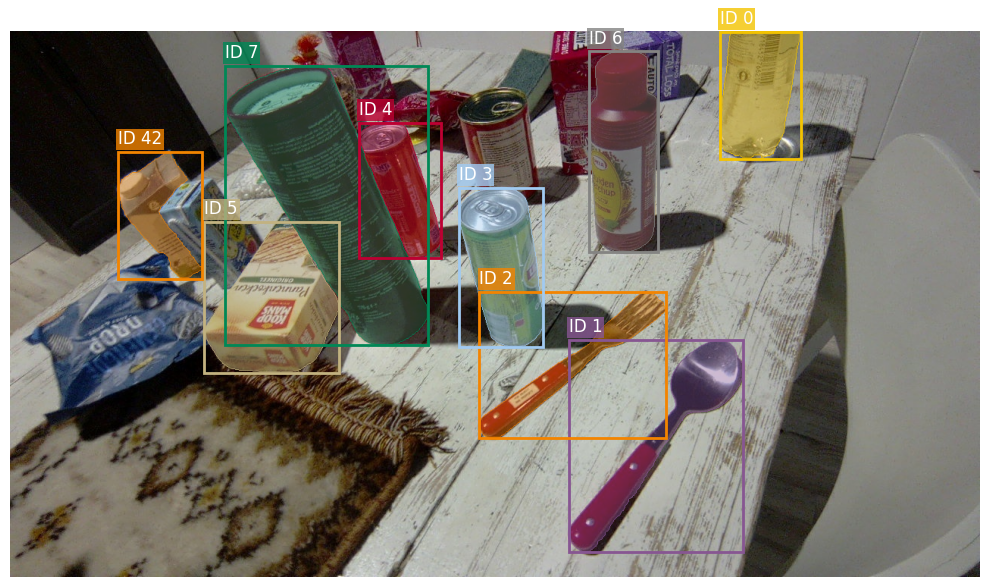

In [6]:
import json

# load an example image
image_b64 = load_image_b64('example_image.jpg')

# load a cached sam2_realtime output to get some object masks
with open("example_artifact_sam2_realtime.json", "r", encoding="utf-8") as f:
    sam2_realtime_output = json.load(f)

# visualize
_ = visualize_sam2({'images': [image_b64]}, sam2_realtime_output)

In [7]:
url = f"{server_base}/infer"

# for each image, prompts is a list of dicts with 'mask' and 'bbox'
prompts = [{'mask': tracklet['mask'], 'bbox': tracklet['box_xyxy']} for tracklet in sam2_realtime_output['artifact']['tracks'][0]]
# for each image, query is a string which instructs how to describe the prompts
query_default = 'Describe the masked region in detail.'
query_short = 'Describe the masked region in one short sentence.'
# the model is okay at instruction following
query_attribute = 'Describe the color of the masked region in one word.'
query = query_short
# for each image, inference parameters determines the generation settings of DAM
inference_parameters = {'temperature': 0.2, 'top_p': 0.5, 'num_beams': 1, 'max_new_tokens': 512, 'max_batch_size': 16}

payload = {'images': [image_b64], 'inference_parameters': [inference_parameters], 'prompts': [prompts], 'queries': [query]}

response = requests.post(url, json=payload, headers=headers)

if response.status_code == 200:
    output = response.json()
else:
    print(f"Request failed with status code: {response.status_code}")

for track_idx in range(len(sam2_realtime_output['artifact']['tracks'][0])):
    # description index 0 because we passed one frame and want the descriptions for that one
    description = output['artifact']['descriptions'][0][track_idx]
    track_id = sam2_realtime_output['artifact']['tracks'][0][track_idx]['track_id']
    print(f"Description for ID {track_id}:\n'{description}'")

Description for ID 0:
'A transparent plastic bottle with a white label featuring black text and a barcode, partially filled with a clear liquid.'
Description for ID 1:
'A spoon with a glossy, metallic bowl and a red handle featuring three evenly spaced silver rivets.'
Description for ID 2:
'A fork with a red handle featuring four silver rivets and a white label with text, leading to a metallic neck and four evenly spaced tines.'
Description for ID 3:
'A cylindrical aluminum can with a green label featuring white text and a red logo on the right side.'
Description for ID 4:
'A cylindrical aluminum can with a metallic finish and a pull tab on top, featuring a predominantly orange label with white and blue text, and a blue logo near the top.'
Description for ID 5:
'A rectangular block of butter wrapped in a white and green packaging with the brand name "Lindt" prominently displayed in red and white text on the front.'
Description for ID 6:
'A cylindrical bottle with a red cap and a red bo

### Unload Model

In [8]:
url = f"{server_base}/unload"

response = requests.post(url, headers=headers)

if response.status_code == 200:
    output = response.json()
    print(output)
else:
    print(f"Request failed with status code: {response.status_code}")

{'unloaded': True}


In [9]:
#with open("example_artifact_dam.json", "w", encoding="utf-8") as f:
#    json.dump(output, f, ensure_ascii=False, indent=4)